# Multi-class Classification

**Import third-party libraries and modules**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import scipy.optimize as opt

from displayData import displayData
from sigmoid import sigmoid
from predictOneVsAll import predictOneVsAll
from lrCostFunction import lrCostFunction
from gradient import gradient
from oneVsAll import oneVsAll

## 1. Multi-class Classification
For this exercise, we will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognized zip codes (postal codes)
on email envelopes to recognizing amounts written on bank checks.

First of all, we will extend our previous implementation of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset
We are given a data set in **ex3data1.mat** that contains 5000 examples training examples of handwritten digits.

We will use **loadmat** function of Scipy library to load this data. (https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.io.loadmat.html)

In [2]:
# We start the exercise by first loading and visualizing the dataset.]
# You will be working with a dataset that contains handwritten digits.

num_labels = 10 # 10 labels, from 1 to 10

# Load training data
print('Loading ...\n')

data = io.loadmat('ex3data1.mat')

X = data['X']
y = data['y']

m = y.shape[0] # number of training examples

Loading ...



There are 5000 training examples in **ex3data1.mat**, where each training example is 20 pixel by 20 pixel grayscale image of of the digit. Each pixel is represeted by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is training example for a handwritten digit image.

$$
X = 
\begin{bmatrix}
\big( x^{(1)} \big)^{T} \\
\big( x^{(2)} \big)^{T} \\
\vdots \\
\big( x^{(m)} \big)^{T}
\end{bmatrix}
$$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

A "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

### 1.2 Visualizing the data
We will begin visualizing a subset of the training set. The code randomly selects 100 rows from X and passes those rows to the **displayData** function. This function maps each row to a 20 pixel by 20 pixel grayscale image and display the images together.

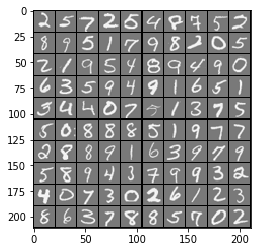

In [3]:
# Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :] # (100, 400)

displayData(sel)

### 1.3 Vectorizing Logistic Regression
 We will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, we will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that our code is well vectorized. In this section, we will implement a vectorized version of logistic regression that does no employ any for loops.
 


#### 1.3.1 Vectorizing the cost function
Recall that in (unregularized) logistic regression, the cost function is

$$
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))]
$$

To compute each element in the summation, we have to compute $h_{\theta}(x^{(i)})$ for every example i, where
$h_{\theta}(x^{(i)}) = g(\theta^{T}x^{(i)})$ and $g(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function. In turns out that we can compute this quickly for all our examples by using matrix multilication. Let us define $X$ and $\theta$ as

$$
X = 
\begin{bmatrix}
\big( x^{(1)} \big)^{T} \\
\big( x^{(2)} \big)^{T} \\
\vdots \\
\big( x^{(m)} \big)^{T}
\end{bmatrix}
$$

$$
\theta = 
\begin{bmatrix}
\theta_{0} \\
\theta_{1} \\
\vdots \\
\theta_{n}
\end{bmatrix}
$$

Then, by computing the matrix product $X\theta$, we have

$$
X\theta = 
\begin{bmatrix}
\big( x^{(1)} \big)^{T}\theta \\
\big( x^{(2)} \big)^{T}\theta \\
\vdots \\
\big( x^{(m)} \big)^{T}\theta \\
\end{bmatrix}
= 
\begin{bmatrix}
\theta^{T}\big( x^{(1)} \big) \\
\theta^{T}\big( x^{(2)} \big) \\
\vdots \\
\theta^{T}\big( x^{(m)} \big) \\
\end{bmatrix}
$$

In the last equality, we used the fact that $a^{T}b = b^{T}a$ if $a$ and $b$ are vectors.

#### 1.3.2 Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as

$$
\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}\big(h_{\theta}(x^{(i)}) - y^{(i)}\big)x_{j}^{(i)}
$$

To vectorize this operation over the dataset, we start by writing out all the parial derivatives explicitly for all $\theta_{j}$,

$$
\begin{bmatrix}
\frac{\partial J}{\partial \theta_{0}} \\
\frac{\partial J}{\partial \theta_{1}} \\
\frac{\partial J}{\partial \theta_{2}} \\
\vdots \\
\frac{\partial J}{\partial \theta_{n}} \\
\end{bmatrix}
= 
\frac{1}{m}
\begin{bmatrix}
\sum_{i=1}^{m}\Big( \big( h_{\theta}(x^{(i)}) - y^{(i)} \big)x_{0}^{(i)} \Big) \\
\sum_{i=1}^{m}\Big( \big( h_{\theta}(x^{(i)}) - y^{(i)} \big)x_{1}^{(i)} \Big) \\
\sum_{i=1}^{m}\Big( \big( h_{\theta}(x^{(i)}) - y^{(i)} \big)x_{2}^{(i)} \Big) \\
\vdots \\
\sum_{i=1}^{m}\Big( \big( h_{\theta}(x^{(i)}) - y^{(i)} \big)x_{n}^{(i)} \Big)
\end{bmatrix}
= 
\frac{1}{m}\sum_{i=1}^{m}\Big( \big( h_{\theta}(x^{(i)}) - y^{(i)} \big)x^{(i)} \Big)
=
\frac{1}{m}X^{T}\big( h_{\theta}(x) - y \big).
$$

where

$$
h_{\theta}(x) - y = 
\begin{bmatrix}
h_{\theta}(x^{(1)}) - y^{(1)} \\
h_{\theta}(x^{(2)}) - y^{(2)} \\
\vdots \\
h_{\theta}(x^{(m)}) - y^{(m)} \\
\end{bmatrix}
$$

Note that $x^{(i)}$ is a vector, while
$
\big( h_{\theta}(x^{(i)}) - y^{(i)} \big)
$
is a scalar. To understand tha last step  of the derivation, let
$
\beta_{i} = \big( h_{\theta}(x^{(i)}) - y^{(i)} \big)
$
and observe that:

$$
\sum_{i}\beta_{i}x^{(i)} = 
\begin{bmatrix}
x^{(1)} x^{(2)} \ldots x^{(m)}
\end{bmatrix}
\begin{bmatrix}
\beta_{1} \\
\beta_{2} \\
\vdots \\
\beta_{m} \\
\end{bmatrix}
=
X^{T}\beta,
$$

where the values $\beta_{i} = \big( h_{\theta}(x^{(i)}) - y^{(i)} \big)$

#### 1.3.3 Vectorizing regularized logistic regression
After we have implemented vectorization for logistic regression, we will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as

$$
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}[-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}
$$

Note that we should not be regularzing $\theta_{0}$ which is used for the bias term.

Correspondingly, the parial derivative of regularized logistic regression cost for $\theta_{j}$ is defined as

$$
\frac{\partial J(\theta)}{\partial \theta_{0}} = \frac{1}{m}\sum_{i=1}^{m}\big(h_{\theta}(x^{(i)}) - y^{(i)}\big)x_{j}^{(i)}; \big( j = 0 \big)
$$

$$
\frac{\partial J(\theta)}{\partial \theta_{j}} = \Big(\frac{1}{m}\sum_{i=1}^{m}\big(h_{\theta}(x^{(i)}) - y^{(i)}\big)x_{j}^{(i)}\Big) + \frac{\lambda}{m}\theta_{j}; \big( j \ge 1 \big)
$$

In [4]:
## ==================== Part 2a: Vectorization Logistic Regression =========================
# In this part of the exericise, you will reuse your logistic regression 
# code from the last exercise. You task here is to make sure that your
# regularized logistic regression implementation is vectorized. After
# that, you will implement one-vs-all classification for the handwritten
# digit dataset

# Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization')

# theta_t = np.array([[-2], [-1], [1], [2]])
theta_t = np.array([-2, -1, 1, 2])
X_t = np.hstack( (np.ones((5, 1)) , (np.arange(1, 16).reshape((5, 3), order='F')) /10 ))
y_t = np.array([[1], [0], [1], [0], [1]])

lam_bda_t = 3
J = lrCostFunction(theta_t, X_t, y_t, lam_bda_t)
grad = gradient(theta_t, X_t, y_t, lam_bda_t)

print('\nCost: %f\n' % (J))
print('Expected cost: 2.534819\n')
print(grad)
print('Expected gradients:\n')
print('0.146561\n -0.548558\n 0.724722\n 1.398003\n')


Testing lrCostFunction() with regularization

Cost: 2.534819

Expected cost: 2.534819

[ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients:

0.146561
 -0.548558
 0.724722
 1.398003



### 1.4 One-vs-all Classification
We will implement one-vs-all classification by training multiple regularized logistic regression  classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K=10$, but our code should work for any value of $K$.

In particular, our code should return all the classifier parameters in a matrix $\Theta \in \mathbb{R}^{Kx(N+1)}$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. We can do this with a "for" - loop from 1 to $K$, training each classifier independently.

In [6]:
## ============= Part 2b: One-vs-All training ================
print('\nTraining One-vs-All Logistic Regression ...\n')

lam_bda = 0.1
[all_theta] = oneVsAll(X, y, num_labels, lam_bda)

print('Optiaml theta: \n\n')
print(all_theta)


Training One-vs-All Logistic Regression ...

Optiaml theta: 


[[-3.08067604e+00  0.00000000e+00  0.00000000e+00 ...  4.00642847e-03
   1.72577399e-07  0.00000000e+00]
 [-3.30137948e+00  0.00000000e+00  0.00000000e+00 ...  4.16480099e-03
  -4.75978222e-04  0.00000000e+00]
 [-4.88804472e+00  0.00000000e+00  0.00000000e+00 ... -4.91769495e-05
   6.70788020e-07  0.00000000e+00]
 ...
 [-8.92142313e+00  0.00000000e+00  0.00000000e+00 ... -1.21162030e-04
   1.16366011e-05  0.00000000e+00]
 [-4.77585689e+00  0.00000000e+00  0.00000000e+00 ... -1.12679612e-03
   8.70544398e-05  0.00000000e+00]
 [-8.92860783e+00  0.00000000e+00  0.00000000e+00 ... -3.74805411e-04
   2.12748523e-05  0.00000000e+00]]


#### 1.4.1 One-vs-all Prediction
After training our one-vs-all classifier, we can now use it to predict the digit contained in a given image.

The code in **predictOneVsAll** function use one-vs-all classifier to make predictions.
We should see that the training set accuracy is about $94.9\%$

In [7]:
## ============================= Part 3: Predict One-Vs-All ===========================
pred = predictOneVsAll(all_theta, X) # (5000,)

print('\nTraining set Accurcy: %.2f\n' % (np.mean(np.double(pred == y.flatten())) * 100))


Training set Accurcy: 95.04

